# ZNE with indirect-control VQE
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: Noise-free time-evolution with XY, Ising, and Heisenberg Hamiltonians.
- Constraint: True

## (1) Import and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from tabulate import tabulate

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

# Others
plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}

plot_export_names = {
    "xy": "xy_ansatz_noise_free_tevo.eps",
    "heisenberg": "heisenberg_ansatz_noise_free_tevo.eps",
    "ising": "ising_ansatz_noise_free_tevo.eps",
    "compiled": "compiled.eps",
    "heisenberg_further1": "heisenberg_ansatz_further_ric3.eps"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
    ]

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [3]:
base_path = "data"
models = ["xy"]

ALL_RAW_DATA = {
    model: {
        "vqe": [],
        "redundant": [],
        "zne": [],
        "noiseoff": []  # Added to match the original structure
    } for model in models
}

for model in models:
    model_path = os.path.join(base_path, model)
    
    try:
        filenames = os.listdir(model_path)
    except Exception as e:
        print(f"[ERROR] Failed to list files in {model_path}: {e}")
        continue

    for filename in filenames:
        if not filename.endswith(".json"):
            continue

        filepath = os.path.join(model_path, filename)
        
        try:
            with open(filepath, "r") as f:
                data = json.load(f)
        except json.JSONDecodeError:
            print(f"[ERROR] Failed to parse JSON in file: {filepath}")
            continue
        except Exception as e:
            print(f"[ERROR] Failed to load file {filepath}: {e}")
            continue

        filename_lower = filename.lower()
        if filename_lower.endswith("_vqe.json"):
            ALL_RAW_DATA[model]["vqe"].append(data)
        elif filename_lower.endswith("_redundant.json"):
            ALL_RAW_DATA[model]["redundant"].append(data)
        elif filename_lower.endswith("_zne.json"):
            ALL_RAW_DATA[model]["zne"].append(data)
        elif filename_lower.endswith("_noise_off.json"):
            ALL_RAW_DATA[model]["noiseoff"].append(data)


## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.




### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [4]:
exact_sol: float = -8.566772233505624
print(f"Exact solution: {exact_sol}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

In [5]:
noise_levels: list=[13, 47]
extrapolated_noise: int = 0

### (C) Processing raw data

In [6]:
ALL_PROCESSED_DATA = {
    model: {
        "vqe": {},
        "redundant": {},
        "zne": {},
        "noiseoff": {}  # Added to match the original structure
    } for model in models
}

for model in models:
    
    ALL_PROCESSED_DATA[model]["vqe"] = {
        "mean": np.mean(
                    ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
                ),
        "std": np.std(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        )
    }

    ALL_PROCESSED_DATA[model]["redundant"] = {
        "noise_levels": noise_levels,
        "mean": [
            np.mean(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            ),
            np.mean(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            )
        ],
        "std": [
            np.std(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][0][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            ),
            np.std(
                [ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][1][4] for i in range(len(ALL_RAW_DATA[model]["redundant"]))]

            )
        ],
    }

    ALL_PROCESSED_DATA[model]["zne"] = {
        "mean": np.mean(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        ),
        "std": np.std(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"]for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        )
    }

    ALL_PROCESSED_DATA[model]["noiseoff"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        )
    }

In [7]:
ALL_PROCESSED_DATA

{'xy': {'vqe': {'mean': -6.435504654927141, 'std': 0.07144654504058062},
  'redundant': {'noise_levels': [13, 47],
   'mean': [-6.4355046549270964, -3.295143445760236],
   'std': [0.07144654504058054, 0.10699332304001415]},
  'zne': {'mean': -7.636230999608543, 'std': 0.07320688190321177},
  'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}}

In [8]:
# Prepare rows for tabulation
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:  # ignore empty "noiseoff"
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])

# Print table
headers = ["Model", "Category", "Mean", "Std"]
print(tabulate(rows, headers=headers))

Model    Category                  Mean        Std
-------  --------------------  --------  ---------
xy       vqe                   -6.4355   0.0714465
xy       redundant (noise=13)  -6.4355   0.0714465
xy       redundant (noise=47)  -3.29514  0.106993
xy       zne                   -7.63623  0.0732069
xy       noiseoff              -8.36934  0.15125


## (4) Plot

Finally we can plot the results.

### (A) XY ansatz plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


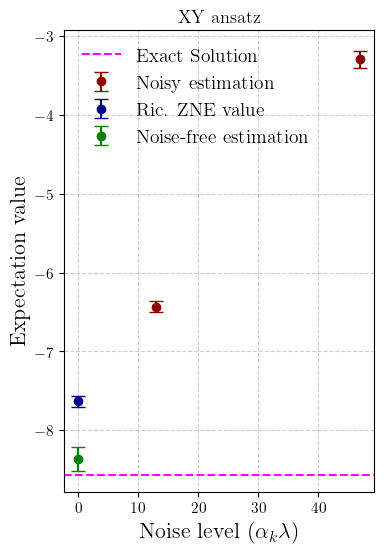

Figure saved as (in 'plots' folder): xy_ansatz_ric.eps


In [9]:
# Plot size
plt.figure(figsize=(4, 6))
# PLot name
plot_name: str= "xy_ansatz_ric.eps"
DATA= ALL_PROCESSED_DATA["xy"]

# Noisy estimation
plt.errorbar(
    x=noise_levels,
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=extrapolated_noise, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_titles["xy"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_name}", format="eps")
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_name)

## (5) Summary